<h1 class='font-effect-3d' style='font-family:Monoton; color:#ff00cc;'>Python Modules, Styling, and Helpful Functions</h1>

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Monoton|Roboto&effect=3d'); 
h1 {text-shadow:4px 4px 4px #aaa;} 
span {font-family:Roboto; color:midnightblue; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:#ff6eff;}
div.input_prompt {color:#ff00cc;} 
div.output_area pre,div.output_subarea {font-family:Roboto; font-size:15px; color:#ff6eff;}
div.output_stderr pre {background-color:ghostwhite;}
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np,xgboost as xgb
import pylab as pl,seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics,neighbors,ensemble
N1,N2=10**4,10**3

In [3]:
def ohe(x): 
    return OneHotEncoder(n_values='auto').fit(x.reshape(-1,1))\
           .transform(x.reshape(-1,1)).toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def deprocess(x):
    x=(x/2+.5)*255
    x=np.clip(x,0,255)
    x=np.uint8(x)
    return x.reshape(28,28)
def display_images(images):
    n_images=len(images)
    rows=4; cols=n_images//rows    
    pl.figure(figsize=(cols,rows))    
    for i in range(n_images):
        img=deprocess(images[i])
        pl.subplot(rows,cols,i+1)
        pl.imshow(img,cmap=pl.cm.bone)
        pl.xticks([]); pl.yticks([])
    pl.tight_layout(); pl.show()

<h1 class='font-effect-3d' style='font-family:Monoton; color:#ff00cc;'> Data Loading and Preprocessing</h1>

In [4]:
train=pd.read_csv("../input/train.csv")
train_labels=train["label"].values.astype('int16')
ctrain_labels=ohe(train_labels)
train_images=train.drop(labels=["label"],axis=1) 
train_images=train_images.values.astype('float32')/255
train_images=(train_images-.5)*2
train_labels.shape,ctrain_labels.shape,train_images.shape

((42000,), (42000, 10), (42000, 784))

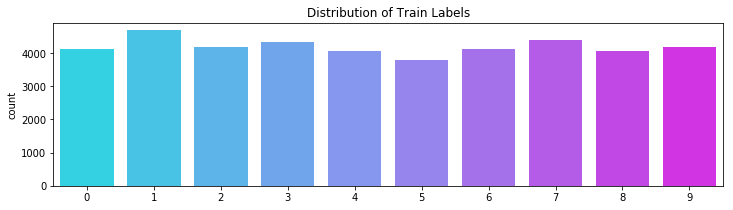

In [5]:
pl.figure(figsize=(12,3))
sn.countplot(train_labels,palette="cool")
pl.title('Distribution of Train Labels');

In [6]:
x_train,x_valid,x_test,\
y_train,y_valid,y_test=tts(train_images,ctrain_labels)
ny_train=np.array([np.argmax(y) for y in y_train])
ny_valid=np.array([np.argmax(y) for y in y_valid])
ny_test=np.array([np.argmax(y) for y in y_test])
x_train2,x_valid2,x_test2=x_train[:N1],x_valid[:N2],x_test[:N2]
y_train2,y_valid2,y_test2=y_train[:N1],y_valid[:N2],y_test[:N2]
ny_train2,ny_valid2,ny_test2=ny_train[:N1],ny_valid[:N2],ny_test[:N2]
sh=[el.shape for el in [x_train,x_valid,x_test,
                        y_train,y_valid,y_test]]
pd.DataFrame(sh)

,0,1
0,33600,784
1,4200,784
2,4200,784
3,33600,10
4,4200,10
5,4200,10


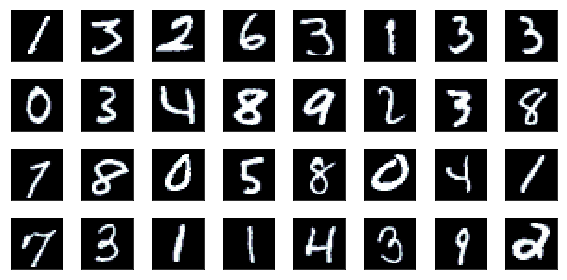

In [7]:
display_images(x_train[:32])

<h1 class='font-effect-3d' style='font-family:Monoton; color:#ff00cc;'>Neighbors & Ensemble Classifiers</h1>

In [8]:
classifier_list,classifier_names,clf_datasets=[],[],[]
acc_train,acc_test,loss_train,loss_test=[],[],[],[]

In [9]:
def classifier_fit_score(classifier,classifier_name,clf_dataset, 
                         x_train,x_test,y_train,y_test):    
    classifier_list.append(str(classifier))
    classifier_names.append(str(classifier_name))
    clf_datasets.append(str(clf_dataset))    
    clf=classifier; clf.fit(x_train,y_train)    
    y_clf_train=clf.predict(x_train)
    y_clf_test=clf.predict(x_test)        
    acc_clf_train=round(metrics.accuracy_score(y_train,y_clf_train),6)
    acc_train.append(acc_clf_train)
    acc_clf_test=round(metrics.accuracy_score(y_test,y_clf_test),6)
    acc_test.append(acc_clf_test)   
    loss_clf_train=round(metrics.hamming_loss(y_train,y_clf_train),4)
    loss_train.append(loss_clf_train)
    loss_clf_test = round(metrics.hamming_loss(y_test,y_clf_test),4)
    loss_test.append(loss_clf_test)    
    return [y_clf_train,y_clf_test,acc_clf_train,acc_clf_test, 
            loss_clf_train,loss_clf_test]

In [10]:
def get_classifier_results():
    results={'classifier':classifier_list,'classifier_name':classifier_names,
            'clf_dataset':clf_datasets,'acc_train':acc_train,'acc_test':acc_test,
            'loss_train':loss_train,'loss_test':loss_test}
    df_results=pd.DataFrame(results)   
    df_list=['classifier_name','acc_train','acc_test','loss_train','loss_test']               
    return df_results,df_results[df_list]

In [11]:
clf1=neighbors.KNeighborsClassifier()
clf2=ensemble.RandomForestClassifier(n_estimators=64,max_depth=11) 
clf3=ensemble.GradientBoostingClassifier()

In [12]:
y_knc_train,y_knc_test=\
classifier_fit_score(clf1,'KNeighborsClassifier','digits',
                     x_train2,x_test2,ny_train2,ny_test2)[:2]

In [13]:
y_rfc_train,y_rfc_test=\
classifier_fit_score(clf2,'RandomForestClassifier','digits',
                     x_train2,x_test2,ny_train2,ny_test2)[:2]

In [14]:
y_gbc_train,y_gbc_test=\
classifier_fit_score(clf3,'GradientBoostingClassifier','digits',
                     x_train2,x_test2,ny_train2,ny_test2)[:2]

<h1 class='font-effect-3d' style='font-family:Monoton; color:#ff00cc;'>Classification  Results</h1>

In [15]:
df_results,df_results2=get_classifier_results()
df_results2.sort_values('acc_test',ascending=False)

,classifier_name,acc_train,acc_test,loss_train,loss_test
1,RandomForestClassifier,0.9953,0.948,0.0047,0.052
0,KNeighborsClassifier,0.9685,0.943,0.0315,0.057
2,GradientBoostingClassifier,0.9919,0.933,0.0081,0.067


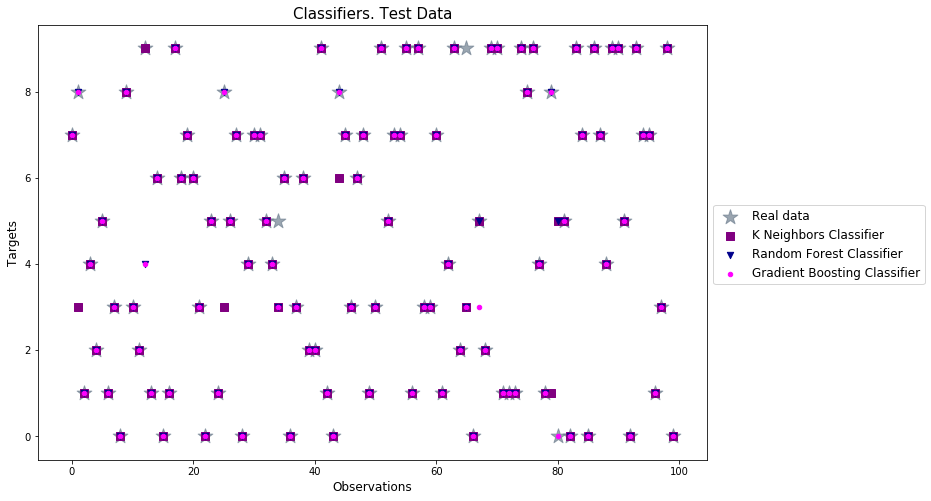

In [16]:
pl.figure(figsize=(12,8)); n=100; x=range(n)
pl.scatter(x,ny_test2[:n],marker='*',s=240, 
            color='slategray',alpha=.7,label='Real data')
pl.scatter(x,y_knc_test[:n],marker='s',s=60, 
            color='purple',label='K Neighbors Classifier')
pl.scatter(x,y_rfc_test[:n],marker='v',s=40, 
color='darkblue',label='Random Forest Classifier')
pl.scatter(x,y_gbc_test[:n],marker='o',s=20, 
color='magenta',label='Gradient Boosting Classifier')
pl.xlabel('Observations',fontsize=12)
pl.ylabel('Targets',fontsize=12)
pl.title('Classifiers. Test Data',fontsize=15)
pl.legend(bbox_to_anchor=[1.,.6],fontsize=12);

<h1 class='font-effect-3d' style='font-family:Monoton; color:#ff00cc;'>XGB Classifier</h1>

In [17]:
clf=xgb.XGBClassifier(objective="multi:softprob",verbosity=2,
                      random_state=42,max_depth=11)
clf.fit(x_train2,ny_train2,eval_metric='mlogloss',
        eval_set=[(x_train2,ny_train2),(x_valid2,ny_valid2)])
print(clf.evals_result())

[0]	validation_0-mlogloss:1.90562	validation_1-mlogloss:1.95292
[1]	validation_0-mlogloss:1.63875	validation_1-mlogloss:1.72303
[2]	validation_0-mlogloss:1.43657	validation_1-mlogloss:1.54618
[3]	validation_0-mlogloss:1.27295	validation_1-mlogloss:1.40422
[4]	validation_0-mlogloss:1.13589	validation_1-mlogloss:1.28516
[5]	validation_0-mlogloss:1.01894	validation_1-mlogloss:1.18259
[6]	validation_0-mlogloss:0.917476	validation_1-mlogloss:1.09382
[7]	validation_0-mlogloss:0.828662	validation_1-mlogloss:1.0163
[8]	validation_0-mlogloss:0.750642	validation_1-mlogloss:0.947555
[9]	validation_0-mlogloss:0.681203	validation_1-mlogloss:0.886784
[10]	validation_0-mlogloss:0.619578	validation_1-mlogloss:0.833934
[11]	validation_0-mlogloss:0.563726	validation_1-mlogloss:0.784754
[12]	validation_0-mlogloss:0.513757	validation_1-mlogloss:0.741359
[13]	validation_0-mlogloss:0.468601	validation_1-mlogloss:0.701397
[14]	validation_0-mlogloss:0.428183	validation_1-mlogloss:0.665161
[15]	validation_0-ml

In [18]:
y_xgb_train=clf.predict(x_train2)
y_xgb_valid=clf.predict(x_valid2)
y_xgb_test=clf.predict(x_test2)
for [y,py] in [[ny_train2,y_xgb_train],
               [ny_valid2,y_xgb_valid],
               [ny_test2,y_xgb_test]]:
    print(metrics.accuracy_score(y,py))
    print(metrics.confusion_matrix(y,py))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1.0
[[ 990    0    0    0    0    0    0    0    0    0]
 [   0 1096    0    0    0    0    0    0    0    0]
 [   0    0 1000    0    0    0    0    0    0    0]
 [   0    0    0 1046    0    0    0    0    0    0]
 [   0    0    0    0  955    0    0    0    0    0]
 [   0    0    0    0    0  895    0    0    0    0]
 [   0    0    0    0    0    0 1038    0    0    0]
 [   0    0    0    0    0    0    0 1066    0    0]
 [   0    0    0    0    0    0    0    0  925    0]
 [   0    0    0    0    0    0    0    0    0  989]]
0.94
[[102   0   0   0   0   0   0   0   0   0]
 [  0 118   0   0   0   2   0   0   1   0]
 [  1   0 116   2   0   0   1   2   2   0]
 [  0   0   3  88   0   0   0   1   1   1]
 [  0   0   0   0  94   0   0   3   1   3]
 [  1   0   1   3   0  83   1   1   1   0]
 [  0   0   0   0   2   3  71   1   0   0]
 [  1   0   5   0   0   0   0  77   0   2]
 [  0   0   2   0   1   1   0   1  89   2]
 [  0   0   0   0   2   1   0   3   1 102]]
0.953
[[104   0   0   0   1  

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
